# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [3]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [4]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(9.02, '2023-11-30')

(9.65,
 59    2024-03-01
 Name: date, dtype: object)

9 0.21 1.87
Bull
1.87


### regression_line(X, Y)
regression_ratio(df, window=10):

9.03 -0.03
Above
-0.03


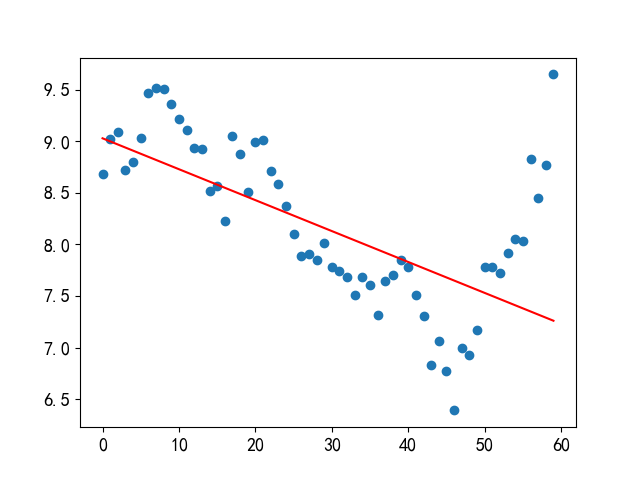

In [5]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.03 -0.03
Above
-0.03


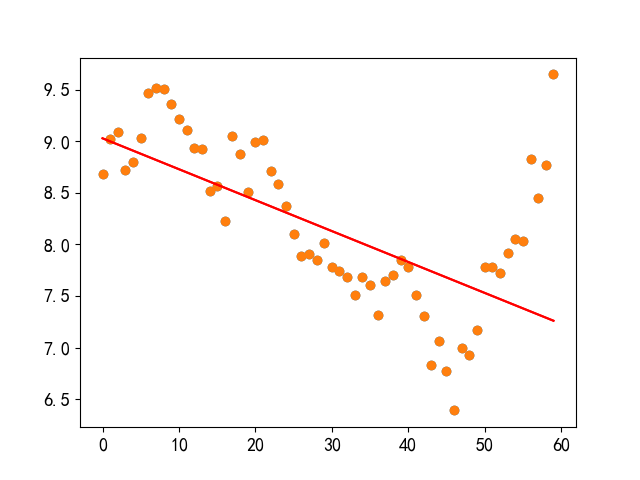

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [7]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'max5', 'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean',
       'hv', 'lv'],
      dtype='object', length=183)

### check_postion_vol_price

In [8]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high   low  close          vol        amount  \
59  2024-03-01  601360  8.78  9.65  8.73   9.65  348081135.0  3.241301e+09   

    ma5d  ma10d  ...  hmax  high4  low4  lastdu4  lmin  min5  cmean  \
59  8.75    8.3  ...  8.18   9.17  7.92     1.16  6.19  7.87   7.88   

             hv          lv  Positon  
59  286514969.0  54934971.0  Neutral  

[1 rows x 184 columns]

In [9]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=184)

0    2023-11-30
1    2023-12-01
2    2023-12-04
Name: date, dtype: object

59   2024-03-01
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:-0.03 


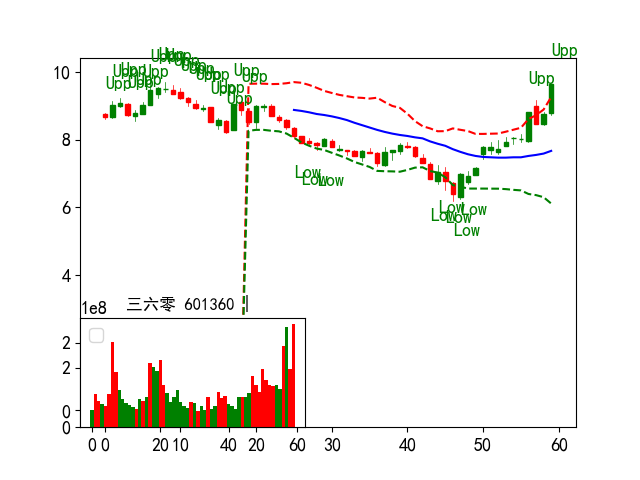

In [10]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [11]:
'code' in dfc.columns

True

### show_channel_mpl

In [12]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [13]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [14]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [15]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 4959
1.86 (4959,) 300163 (334, 6)
resample:D
use time:11.76


In [16]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open   high   low  close          vol        amount
date                                                           
2024-03-01  9.99  10.01  9.82   9.89  109265177.0  1.082469e+09

### Test InStock

In [17]:
df.loc['301083'][:2]

open   high    low  close        vol      amount
date                                                         
2022-10-12  10.83  11.34  10.66  11.28  1111100.0  12353461.0
2022-10-13  11.28  11.59  11.27  11.47   787700.0   9055665.0

## ra_diff

In [18]:
tail_days = 60

In [19]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [20]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [21]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [22]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [23]:
# df.loc['000002'][-10:]

## sina_dm

In [24]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2024-03-01',
 code
 600844    丹化科技
 Name: name, dtype: object)

In [25]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2024-03/02/24 17:18:25'

code
601599   2024-03-01 15:00:00
300686   2024-03-01 15:00:00
Name: ticktime, dtype: datetime64[ns]

1578.426260538896

### Combine ratio and idx

In [26]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [27]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [28]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
h5code='603019'
h5.loc[h5code][-3:]
code_muti = '603019'
# h5.loc[code_muti][:2]

freq = 'D'
# freq = '5M'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
# run_col = ['close']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol = round(allvol / 10 / 1000 / 1000,2)
print("总量:%s 亿"%(allvol))
mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
#全局占比
mdf['volume'] = mdf.amount.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')
mdf.loc[h5code]

['/all_20']
G:\sina_MultiIndex_data.h5


(2911688, 6)

close  high    low  llastp     volume  lastbuy
ticktime                                                           
2024-03-01 14:59:59  53.46  54.0  48.71   49.71  211810299    48.95
2024-03-01 14:59:59  53.46  54.0  48.71   49.71  211810299    51.90
2024-03-01 15:00:00  53.50  54.0  48.71   49.71  214532103    51.90

1.0

总量:9070.05 亿


ticktime    2024-03-31 00:00:00
close                 51.771905
volume                     1.22
vol                      214.53
amount                   111.07
Name: 603019, dtype: object

In [29]:
mdf[:2]
mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2024-03-31  10.480051    0.21  182.81   19.16
000002 2024-03-31   9.903980    0.12  109.27   10.82

ticktime    2024-03-31 00:00:00
close                 51.771905
volume                     1.22
vol                      214.53
amount                   111.07
Name: 603019, dtype: object

In [30]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2024-03-01'

In [31]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2024-03-31 00:00:00
close                   9.90398
volume                     0.12
vol                      109.27
amount                    10.82
Name: 000002, dtype: object

###  实时成交量个股Top

In [32]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [33]:
nowdf.shape,top20_nd

((4897, 5),
         volume  name
 code                
 603019    1.22  中科曙光
 000063    1.07  中兴通讯
 000977    0.86  浪潮信息
 601127    0.82   赛力斯
 000938    0.75  紫光股份
 002049    0.75  紫光国微
 002230    0.71  科大讯飞
 300308    0.67  中际旭创
 300364    0.64  中文在线
 601138    0.54  工业富联
 300502    0.51   新易盛
 300750    0.51  宁德时代
 300418    0.51  昆仑万维
 600519    0.50  贵州茅台
 002456    0.48   欧菲光
 000628    0.47  高新发展
 300059    0.44  东方财富
 002475    0.43  立讯精密
 000625    0.38  长安汽车
 300735    0.38  光弘科技)

### 合并实时成交量及SinaDM

In [34]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name  open  llastp  now  trade  high   low   buy  sell    volume  ...  \
code                                                                      ...   
600844  丹化科技  2.71     2.7  2.7    0.0  2.75  2.66  2.69   2.7  13701500  ...   

        close      nvol         timel  lastbuy  nlow  nhigh  nclose  nstd  \
code                                                                        
600844    2.7  13701500  1.709277e+09     2.71  2.69   2.75    2.69  -2.0   

         vol  amount  
code                  
600844  13.7    0.37  

[1 rows x 44 columns]

## check HDF LastDate

In [35]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4959, 7)

In [36]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open       high        low      close          vol  \
code   date                                                                  
999999 2024-03-01  3013.8229  3032.2315  3003.7632  3027.0204  379132184.0   

                         amount  ra_diff  
code   date                               
999999 2024-03-01  4.429842e+11     1.12

In [37]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [38]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [39]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [40]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [41]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2024-02-29   8.46   9.07  8.26  8.24
2024-03-01   8.43   9.03  8.36  8.22

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma10, ma5, ma20, ma250, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 28 columns]

(60, 28)


In [42]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat    close  volsum5d     hmax    lmin  perc1d  \
date                                                                      
2024-02-29     1.07  165.77  1695.00      22.7  1737.93  1581.0    0.80   
2024-03-01     1.07  164.08  1685.06      11.4  1737.93  1581.0   -0.59   

               ma20   ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                     
2024-02-29  1667.39  406.42 -22.31  44.33 -19.18   0.05  19.80    0.00   
2024-03-01  1669.74  413.12   8.52 -22.31  44.33 -19.18   0.05   -0.26   

            perc5d    ma51d  ra_diff  
date                                  
2024-02-29   -1.36  1695.02     1.07  
2024-03-01   -1.69  1689.22     1.07

### Append Now SinaTo MultiIndex dfNow

In [43]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfNow=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days/2),sinadm)
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open   high    low  close          vol        amount  \
code   date                                                                
000001 2024-02-29  10.42  10.59  10.41  10.59  184534423.0  1.936021e+09   
       2024-03-01  10.59  10.60  10.43  10.49  182810290.0  1.917689e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2024-02-29     1.17  10.40  10.59   9.96  ...    0.57   -2.40   -2.84   
       2024-03-01     1.16  10.48  10.52  10.01  ...   -0.10   -0.38   -3.32   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2024-02-29 -40.14  55.54 -30.77 -19.76 -27.52     -62.7  10.59  
       2024-03-01  -0.93 -40.14  55.54 -30.77 -19.76     -36.1  10.52  

[2 rows x 29 columns]

In [44]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'].shape


(60, 29)

### Xratio and tail 60 MultiIndex 

In [45]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [89]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high   low  close         vol        amount  ra_diff  ma10  \
date                                                                            
2023-11-30  37.5  37.74  36.7  37.05  28974964.0  1.075763e+09     1.23  9.83   

              ma5  ma20  ...  perc3d  perc4d  perc5d   vol1d  vol2d  vol3d  \
date                     ...                                                 
2023-11-30  12.89  8.21  ...  452.16  425.53  433.86  736.92 -40.63 -20.14   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2023-11-30  61.72  11.28     749.1  12.89  

[1 rows x 29 columns]

## DFNow Query check

In [116]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2024-03-01


code    date      
002371  2024-03-01    1.50
603019  2024-03-01    0.72
002916  2024-03-01    0.65
300757  2024-03-01    0.61
002049  2024-03-01    0.54
603728  2024-03-01    0.52
301030  2024-03-01    0.50
002230  2024-03-01    0.45
300678  2024-03-01    0.39
300474  2024-03-01    0.33
Name: xratio, dtype: float64

date
2024-02-21     NaN
2024-02-22   -0.31
2024-02-23   -0.24
2024-02-26   -0.18
2024-02-27   -0.11
2024-02-28   -0.10
2024-02-29   -0.05
2024-03-01    0.01
Name: close, dtype: float64

In [48]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2024-02-29    4.97
2024-03-01    5.01
Name: upper, dtype: float64

(60, 29)
xratio:-0.03 ra_diff:1.43


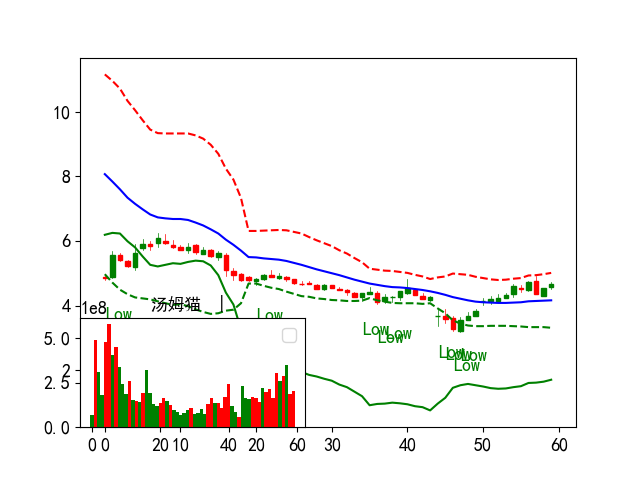

In [90]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

603019 date
2024-02-29    1.65
2024-03-01    1.78
Name: ra_diff, dtype: float64
xratio:-0.02 ra_diff:1.78


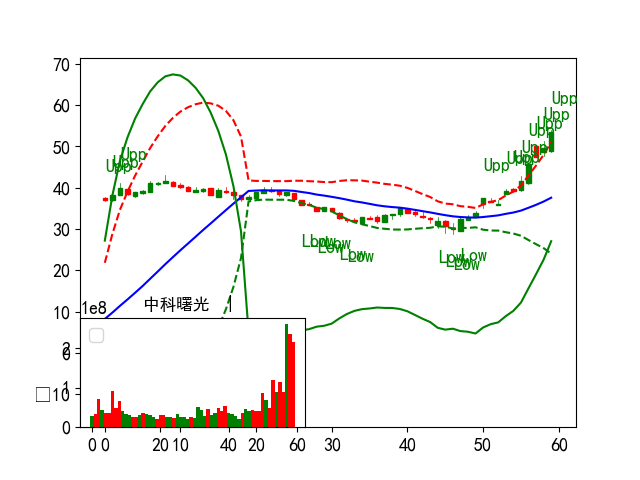

000063 date
2024-02-29    1.38
2024-03-01    1.41
Name: ra_diff, dtype: float64
xratio:-0.01 ra_diff:1.41


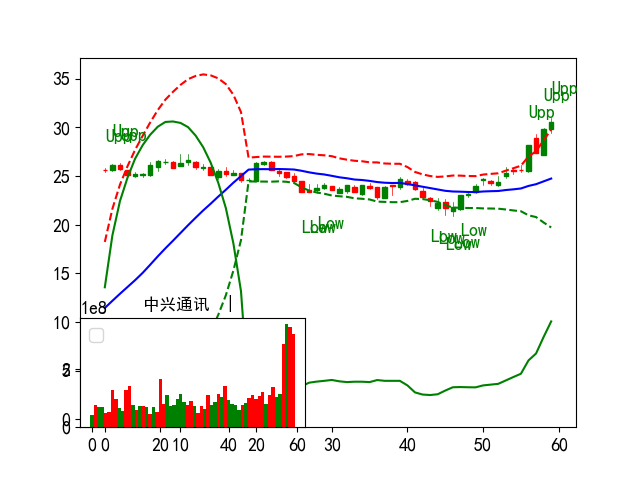

In [91]:
for co in top20_nd.index[:2]:
    print(co,dfNow.loc[co].ra_diff[-2:])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)

In [51]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

Empty DataFrame
Columns: [date, open, high, low, close, vol, amount, ra_diff, ma10, ma5, ma20, ma250, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d, ma51d, xratio, idx]
Index: []

[0 rows x 32 columns]

In [52]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [53]:
df.loc['000002'][-2:]

open   high   low  close          vol        amount  ra_diff
date                                                                    
2024-02-29  9.85  10.04  9.84  10.04  111384138.0  1.104648e+09     1.11
2024-03-01  9.99  10.01  9.82   9.89  109265177.0  1.082469e+09     1.09

In [54]:
dfNow.loc['000002'][-2:]

open   high   low  close          vol        amount  ra_diff  \
date                                                                       
2024-02-29  9.85  10.04  9.84  10.04  111384138.0  1.104648e+09     1.11   
2024-03-01  9.99  10.01  9.82   9.89  109265177.0  1.082469e+09     1.09   

             ma10    ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                            ...                                       
2024-02-29  10.04  10.04  9.86  ...   -1.08  -9.64  46.94 -24.14  16.94   
2024-03-01  10.02   9.98  9.86  ...   -3.04  -1.90  -9.64  46.94 -24.14   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2024-02-29   2.43      32.5  10.04    0.03 -0.02  
2024-03-01  16.94      28.2   9.98    0.03  0.05  

[2 rows x 31 columns]

# 基础处理

In [55]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2024-02-05 2024-03-01


open   high    low  close          vol        amount  \
code   date                                                                
000001 2024-02-29  10.42  10.59  10.41  10.59  184534423.0  1.936021e+09   
       2024-03-01  10.59  10.60  10.43  10.49  182810290.0  1.917689e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2024-02-29     1.17  10.40  10.59   9.96  ...   -2.84 -40.14  55.54   
       2024-03-01     1.16  10.48  10.52  10.01  ...   -3.32  -0.93 -40.14   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2024-02-29 -30.77 -19.76 -27.52     -62.7  10.59    0.07  0.92  
       2024-03-01  55.54 -30.77 -19.76     -36.1  10.52    0.07  0.68  

[2 rows x 31 columns]

Low:2024-02-05


Timestamp('2024-02-05 00:00:00')

In [56]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(9852, 31)
count dd.couts
(code    date      
603979  2024-02-05    14
603960  2024-02-05    14
603379  2024-02-05    14
601899  2024-02-05    14
601607  2024-02-05    14
Name: couts, dtype: int64, (9852, 32))
dt_low:2024-02-05 df:1130 Index(['603979', '603960', '603379', '601899', '601607'], dtype='object', name='code') df_idx:629
Main Down dd :1 MainUP df:1130 couts std:3.4 
time: 0.03  973


In [57]:
dfs_dtlen.loc['002987'][-1:]

open  high   low  close        vol        amount  ra_diff   ma10  \
date                                                                            
2024-03-01  15.87  16.3  15.8  16.18  7669682.0  1.232568e+08     1.34  15.31   

              ma5   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                      ...                                              
2024-03-01  15.75  14.55  ...    3.59  -2.82 -31.13  51.56  -3.13  -4.23   

            volsum5d  ma51d  xratio   idx  
date                                       
2024-03-01      10.3  15.75    0.04  1.59  

[1 rows x 31 columns]

## 最近60天筛选

In [58]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [59]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(1020, 31)
count dd.couts
(code    date      
600820  2024-01-12    19
Name: couts, dtype: int64, (1020, 32))
(code    date      
600820  2024-03-01    19
000685  2024-03-01    14
Name: couts, dtype: int64, (319, 32))
Count:319 32


couts  ra_diff  xratio  idx   hat  close  volsum5d   hmax  \
code   date                                                                    
600213 2024-01-22      2     2.05     0.0  0.0  1.05   8.69     300.9   9.67   
600847 2024-01-17      3     2.03     0.0  0.0  1.12  11.38     -79.6  12.12   
002888 2024-01-15      1     1.93     0.0  0.0  8.99  21.21     412.4  30.95   

                    lmin  perc1d   ma20  ma250   vol1d  vol2d  vol3d  vol4d  \
code   date                                                                   
600213 2024-01-22   8.37    2.36   8.11   7.94  282.75 -42.00  70.08   4.38   
600847 2024-01-17  10.83   -2.65  10.71  10.99   13.84  29.24 -39.23 -56.79   
002888 2024-01-15  17.70   -0.47  19.30  19.57  -39.83  21.74 -22.04 -30.70   

                    vol5d  perc3d  perc5d  
code   date                                
600213 2024-01-22  -14.31   -1.92   -5.65  
600847 2024-01-17  -26.62   -3.15    6.45  
002888 2024-01-15  483.26   -4.72   -9.74

#### filter today

In [60]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [61]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [62]:
dfs.loc['301073'][-5:].ra_diff

date
2024-02-23    1.26
2024-02-26    1.27
2024-02-28    1.21
2024-02-29    1.24
2024-03-01    1.24
Name: ra_diff, dtype: float64

xratio:-0.02 ra_diff:1.09


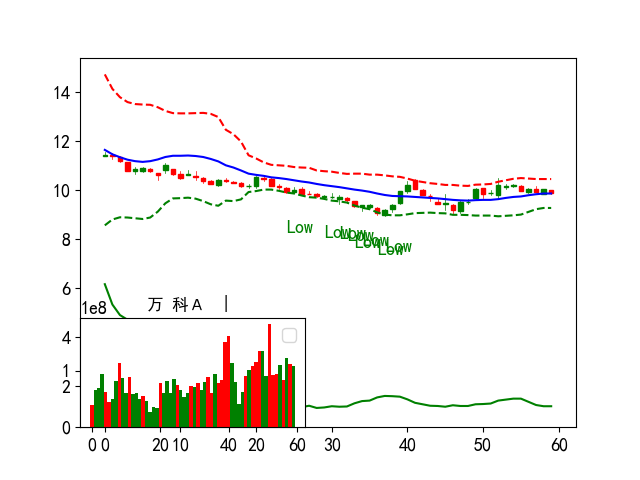

301318 3.08
xratio:0.16 ra_diff:3.08


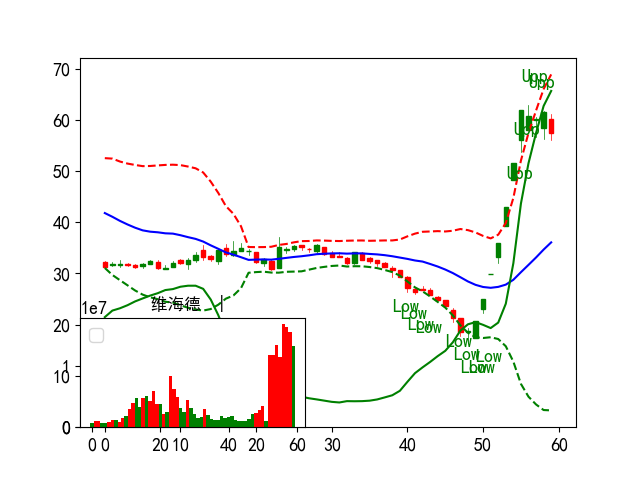

301191 1.57
xratio:-0.41 ra_diff:1.57


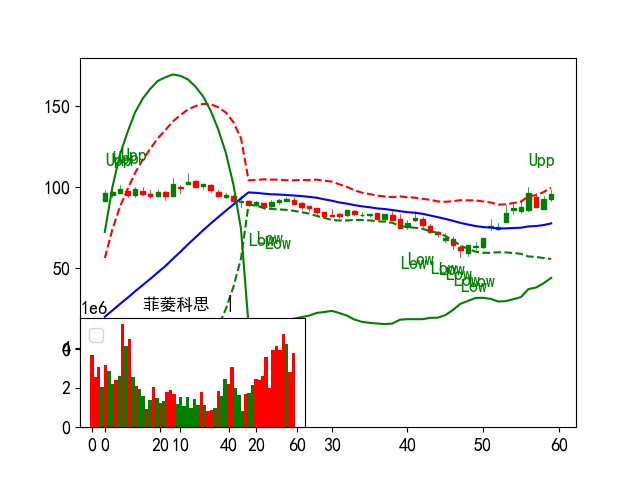

000628 2.17
xratio:-0.1 ra_diff:2.17


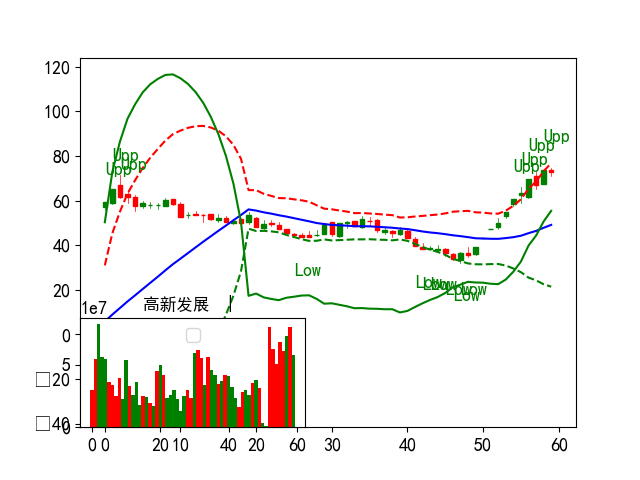

002371 1.35
xratio:0.7 ra_diff:1.35


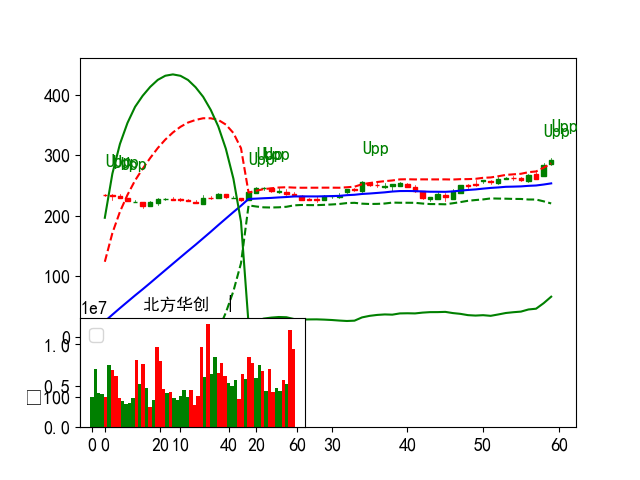

603444 1.27
xratio:-1.55 ra_diff:1.27


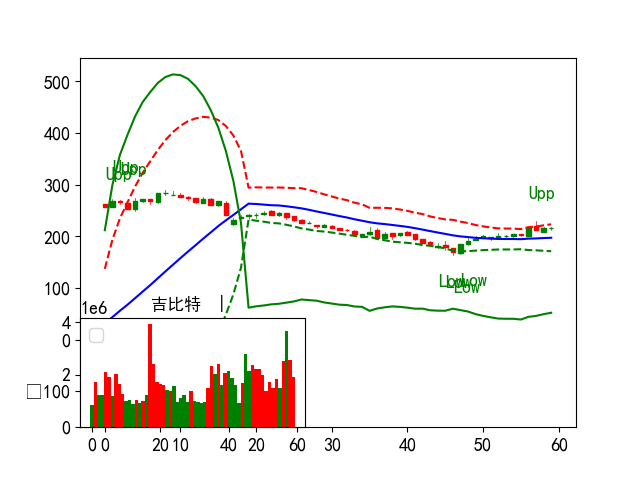

001309 1.5
xratio:-0.38 ra_diff:1.5


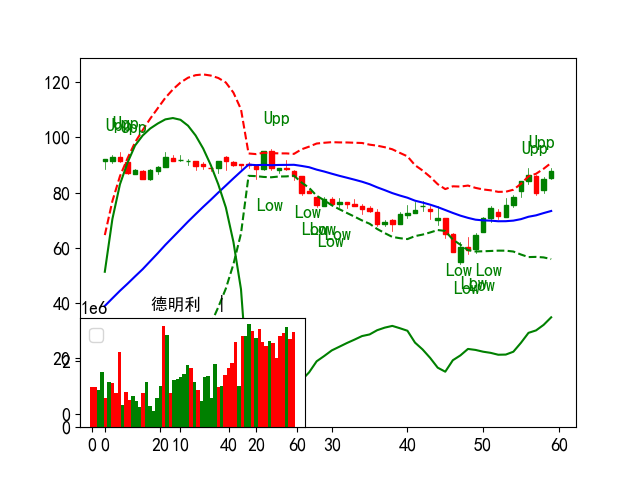

000568 1.22
xratio:-0.56 ra_diff:1.22


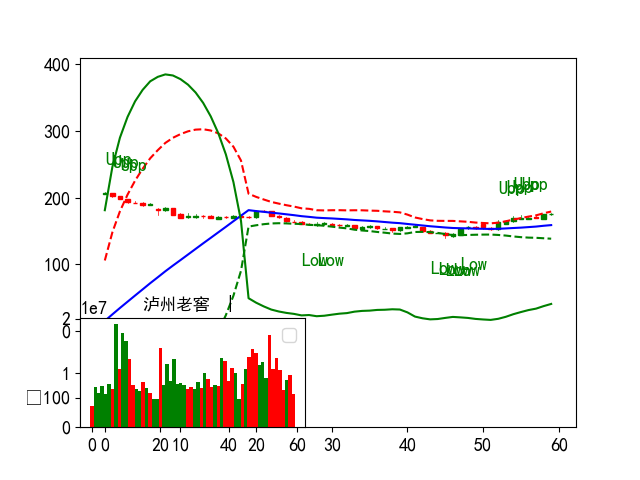

603960 3.25
xratio:0.26 ra_diff:3.25


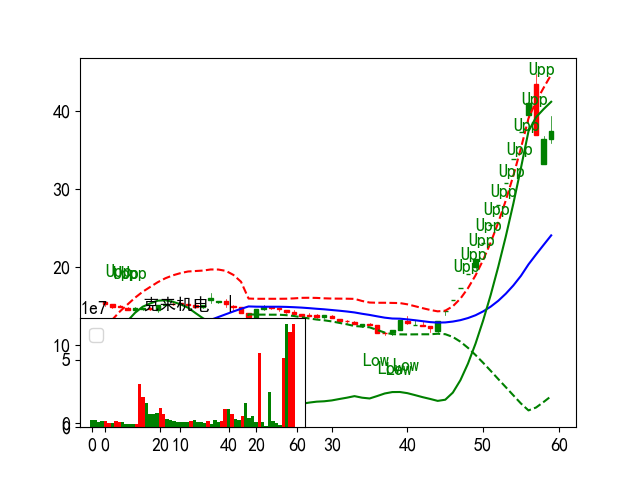

002920 1.28
xratio:-0.79 ra_diff:1.28


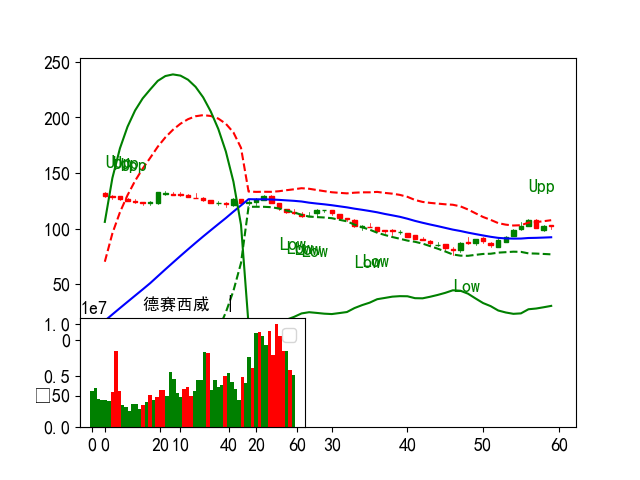

603728 1.86
xratio:-0.58 ra_diff:1.86


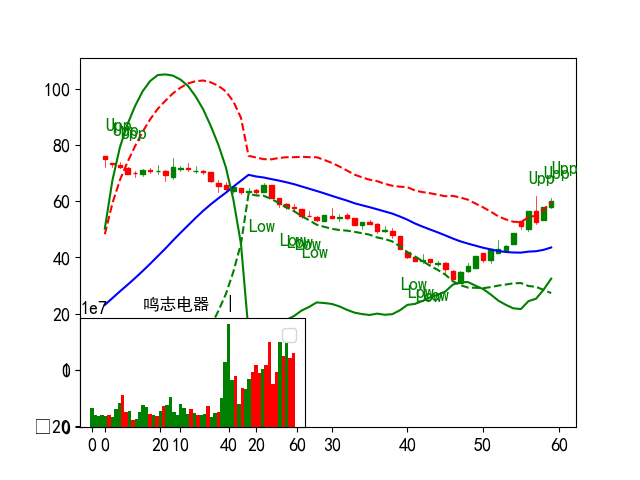

In [93]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [64]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [65]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2024-02-28    1.09
        2024-02-29    1.12
        2024-03-01    1.12
399001  2024-02-28    1.14
        2024-02-29    1.17
        2024-03-01    1.18
399006  2024-02-28    1.13
        2024-02-29    1.17
        2024-03-01    1.18
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [66]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio   idx   hat  close  volsum5d  hmax  lmin  perc1d  \
date                                                                           
2024-02-29     1.31   -0.09  2.16  5.68  12.72      18.8  15.1  9.25    4.78   
2024-03-01     1.36   -0.05  1.94  5.06  13.24      15.1  15.1  9.25    4.09   

             ma20  ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  
date                                                                         
2024-02-29  12.05  12.78 -36.17  -1.74  43.39   2.30  11.01    0.08    6.62  
2024-03-01  11.96  12.79   7.32 -36.17  -1.74  43.39   2.30   -1.85    6.09

## !!! Run-Filter强势Upper

### !!! filterRule test

In [67]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.02 -0.14


'Bear'

-0.14

date
2024-02-26    0.04
2024-02-27    0.03
2024-02-28    0.03
2024-02-29    0.03
2024-03-01    0.02
Name: xratio, dtype: float64

xratio:0.02 ra_diff:1.16


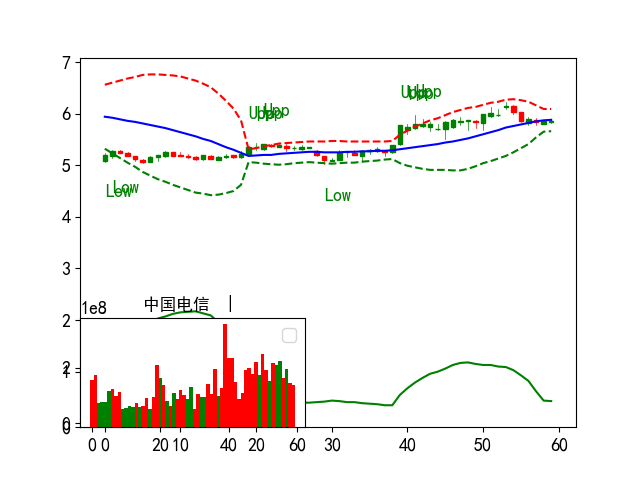

In [94]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [69]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高

30
xratio:0.05 ra_diff:1.27


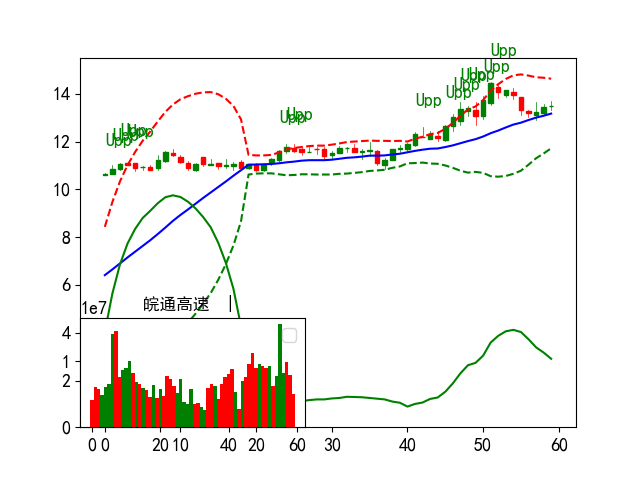

In [95]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [71]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 000651    16
 Name: couts, dtype: int64,
 (286, 41))

Count:286 41


name  couts       date  perc  ra_diff  xratio   idx    hat   close  \
code                                                                         
000651  格力电器     16 2024-03-01  2.46     1.30    0.29  3.03   6.91   40.01   
600690  海尔智家     15 2024-03-01  1.29     1.21    0.12  0.82   2.88   24.40   
000338  潍柴动力     14 2024-03-01 -3.26     1.22    0.11  0.55   2.72   16.33   
000333  美的集团     13 2024-03-01  2.94     1.31    0.30  3.87   7.20   64.47   
000921  海信家电     12 2024-03-01  1.34     1.53    0.23  3.89   6.80   30.19   
600104  上汽集团     11 2024-03-01  0.13     1.14    0.08  0.43   1.99   14.98   
002085  万丰奥威     11 2024-03-01  1.68     1.58    0.09  0.84   3.07    7.28   
600660  福耀玻璃     11 2024-03-01  0.21     1.19    0.25  2.40   6.32   43.38   
300394  天孚通信     11 2024-03-01  0.65     1.87    2.11  6.32  68.67  136.88   
600150  中国船舶     11 2024-03-01  0.45     1.30    0.26  2.75   6.51   35.66   

        volsum5d  ...  ma250  nclose    llow  vol1d  vol2d  vol3d  vol4d  \
code              ...                                                      
000651      56.4  ...  11.45   39.86   38.94  45.05  -3.39   0.08 -28.01   
600690      14.6  ...   9.02   24.36   23.87  16.20  12.50  -7.89 -28.39   
000338     173.4  ...  12.00   16.37   16.24   0.80  -9.60  89.65 -39.20   
000333      11.8  ...  23.57   64.16   62.88 -32.86  92.85  -9.45 -17.84   
000921      44.1  ...  13.80   29.73   29.43 -24.26  -4.54 -49.14  61.60   
600104      49.1  ...   7.43   14.99   14.90 -29.28  -1.10  56.99 -34.44   
002085      42.9  ...   5.76    7.25    7.13 -19.08  41.78  24.62 -32.76   
600660      38.3  ...  15.18   43.37   43.04 -46.28  19.96  42.02 -21.42   
300394      32.1  ...  41.12  136.55  131.69  -5.26  16.68 -22.37  69.01   
600150      28.6  ...  12.84   35.45   35.18 -38.24  15.70  46.24  -7.98   

         vol5d  perc3d  perc5d  
code                            
000651   42.68    2.91    4.96  
600690   22.22    1.92    2.13  
000338  131.75   -2.10    0.31  
000333  -20.88    4.12    8.13  
000921   60.40    2.76   13.71  
600104   56.93    0.60    0.54  
002085   28.32    4.00    9.47  
600660   44.05    3.61    3.80  
300394  -25.92    2.92   14.62  
600150   12.93    5.97    7.31  

[10 rows x 24 columns]

#### !!! hmax Top upper > 1

In [72]:
# dfs_tail9.loc['600103']

In [73]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )[:10]

count dd.couts
compute percent
code
002403    2
Name: couts, dtype: int64 (69, 41)


(code
 002403    2
 Name: couts, dtype: int64,
 (69, 41))

Count:53 41


name  couts       date   perc  ra_diff  xratio   idx    hat  close  \
code                                                                         
002403   爱仕达      2 2024-03-01   9.97     1.95    0.02  4.04   5.33   9.93   
603109  神驰机电      2 2024-03-01   4.62     1.87    0.17  7.86  10.78  21.08   
002611  东方精工      5 2024-03-01  10.04     2.15    0.08  3.70   4.73   8.00   
002639  雪人股份      2 2024-03-01   1.49     1.43    0.02  1.42   2.29   7.50   
300152   新动力      2 2024-03-01   7.90     2.19   -0.00  1.79   2.02   3.55   
002733  雄韬股份      2 2024-03-01  10.01     1.47   -0.01  2.77   4.44  14.83   
600860  京城股份      2 2024-03-01   0.64     1.64    0.00  3.71   5.78  12.61   
000723  美锦能源      2 2024-03-01  10.06     1.61    0.05  1.65   2.52   7.55   
300435  中泰股份      2 2024-03-01   0.00     1.29   -0.02  2.49   3.10  13.91   
000801  四川九洲      2 2024-03-01   5.83     1.47    0.03  1.77   2.87   9.98   

        volsum5d  ...  ma250  nclose   llow    vol1d    vol2d   vol3d  \
code              ...                                                   
002403    1892.8  ...   7.31    9.47   9.03    46.00   -16.28   85.30   
603109    1456.8  ...  13.48   21.59  20.40  1546.13   -80.49   24.01   
002611    1444.2  ...   8.63    8.00   8.00   -95.17  1527.60  106.99   
002639     514.2  ...   6.01    7.68   7.44    46.04    19.90  438.74   
300152     438.5  ...   5.38    3.70   3.50    60.94    23.65  401.67   
002733     381.0  ...  10.90   14.58  14.18   245.21    -9.11  129.88   
600860     345.4  ...  13.30   12.97  12.60    44.96    22.29  246.87   
000723     305.1  ...   4.84    7.54   7.28   131.13     4.15  168.62   
300435     300.2  ...  18.09   13.86  13.61     1.21    12.54  245.81   
000801     285.5  ...   7.64    9.95   9.64   274.48   -20.63   39.14   

          vol4d  vol5d  perc3d  perc5d  
code                                    
002403  1864.45 -86.62    9.24   32.22  
603109   -35.68   2.80   26.61   30.85  
002611    -8.47 -86.77   33.11   61.29  
002639   -33.35  42.87   15.92   20.19  
300152   -30.16 -17.60   55.70   57.08  
002733    -5.01  20.01   16.22   20.28  
600860   -36.19  67.42   21.84   28.02  
000723     8.91  -7.74   23.77   25.21  
300435   -13.76  54.39    9.79   11.01  
000801     1.28  -8.73   11.51   14.71  

[10 rows x 24 columns]

In [74]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [75]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:69 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  \
code                                                                      
300757   罗博特科      2 2024-03-01  15.03     2.20     2.20    0.61  44.50   
300152    新动力      2 2024-03-01   7.90     2.19     2.19   -0.00   1.79   
002611   东方精工      5 2024-03-01  10.04     2.15     2.15    0.08   3.70   
000586   汇源通信      2 2024-03-01  10.00     2.10     2.10   -0.00   5.54   
002875    安奈儿      2 2024-03-01   9.99     2.02     2.02    0.03   6.74   
600678   四川金顶      1 2024-03-01  10.00     1.99     1.99   -0.02   3.42   
002209  达 意 隆      2 2024-03-01   9.97     1.95     1.95   -0.01   4.68   
002403    爱仕达      2 2024-03-01   9.97     1.95     1.95    0.02   4.04   
300293   蓝英装备      1 2024-03-01  15.00     1.92     1.92    0.07   7.17   
603109   神驰机电      2 2024-03-01   4.62     1.87     1.87    0.17   7.86   
301020   密封科技      1 2024-03-01  19.99     1.79     1.79   -0.19   9.20   
603019   中科曙光      8 2024-03-01   7.62     1.78     1.78    0.72  16.10   
002325   洪涛股份      1 2024-03-01   9.83     1.74     1.74    0.00   0.42   
600733   北汽蓝谷      4 2024-03-01   7.23     1.72     1.72    0.04   2.03   
300766   每日互动      1 2024-03-01   6.44     1.71     1.71   -0.05   5.34   
603220   中贝通信      3 2024-03-01   2.58     1.69     1.69    0.26   8.90   
601127    赛力斯      6 2024-03-01   0.40     1.65     1.65    1.36  18.15   
300260   新莱应材      2 2024-03-01   2.15     1.65     1.65   -0.02   7.98   
300475   香农芯创      1 2024-03-01   3.93     1.65     1.65    0.15   6.98   
300471   厚普股份      1 2024-03-01   5.17     1.65     1.65   -0.08   4.61   

          hat  close  ...  ma250  nclose   llow    vol1d    vol2d   vol3d  \
code                  ...                                                   
300757  52.29  94.20  ...  94.71   93.82  82.89    44.25    15.19   13.05   
300152   2.02   3.55  ...   5.38    3.70   3.50    60.94    23.65  401.67   
002611   4.73   8.00  ...   8.63    8.00   8.00   -95.17  1527.60  106.99   
000586   7.09  12.98  ...   7.47   12.98  12.98   -53.33   140.74   -7.81   
002875   7.94  15.97  ...  16.69   15.97  15.97   -49.79   -22.73  -57.57   
600678   4.25   7.70  ...   6.84    7.70   7.70   -91.28   -58.75  251.23   
002209   5.74  11.25  ...   6.05   11.25  11.25   -44.82   -88.03  120.94   
002403   5.33   9.93  ...   7.31    9.47   9.03    46.00   -16.28   85.30   
300293   8.04  17.10  ...  15.93   15.90  15.12    16.61   122.37   -7.20   
603109  10.78  21.08  ...  13.48   21.59  20.40  1546.13   -80.49   24.01   
301020   9.95  21.55  ...  25.51   21.55  20.81   148.96   -11.04   71.67   
603019  27.05  53.50  ...  14.49   51.76  48.71    -8.64   -10.40  192.57   
002325   0.78   1.90  ...   6.72    1.90   1.90   -78.40   -51.41   27.74   
600733   2.85   6.38  ...   5.06    6.16   5.84     0.08    -2.35   10.60   
300766   6.29  14.70  ...  24.40   14.67  13.81    15.24    73.52   45.35   
603220  16.28  34.54  ...  14.14   34.28  33.05    -4.26     1.95   27.55   
601127  46.89  92.30  ...  27.94   92.33  90.00   -22.30    -4.00   10.16   
300260  10.99  28.57  ...  10.82   28.54  27.81   118.92    33.19    4.39   
300475  14.17  34.42  ...  16.17   33.77  32.67   -17.28    12.56   37.19   
300471   5.06  12.61  ...  25.95   12.75  12.33    41.61    83.76  138.06   

          vol4d  vol5d  perc3d  perc5d  
code                                    
300757    12.09 -12.31   29.22   43.75  
300152   -30.16 -17.60   55.70   57.08  
002611    -8.47 -86.77   33.11   61.29  
000586   -16.22 -20.50   33.13   40.17  
002875   -14.40 -22.52   33.08   46.78  
600678   -33.66  -7.33   33.22   49.22  
002209   -13.78  30.32   33.14   44.42  
002403  1864.45 -86.62    9.24   32.22  
300293   -15.23   6.85   20.93   30.53  
603109   -35.68   2.80   26.61   30.85  
301020    10.69  50.75   36.31   46.20  
603019   -21.51  26.64   16.66   36.06  
002325    56.87 -21.20   32.87   26.67  
600733    24.04  76.59   11.15   29.41  
300766 

xratio:-0.09 ra_diff:1.44


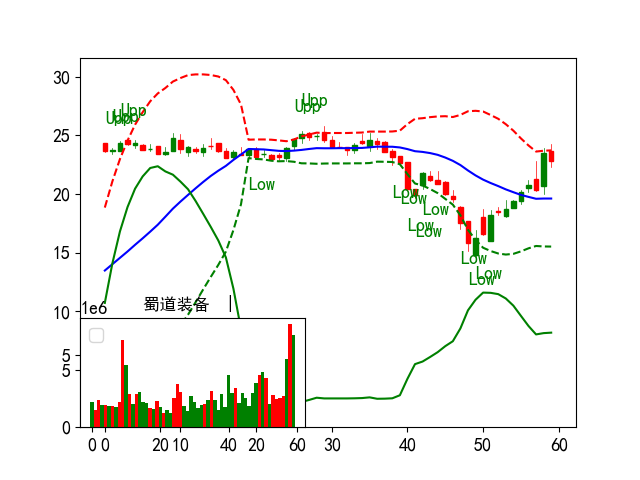

In [98]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [77]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1][:20])
# show_tdx_data(df_mask250.loc[code_t])

(622, 31)

count dd.couts
(code    date      
603019  2024-02-23    6
        2024-02-26    6
        2024-02-27    6
Name: couts, dtype: int64, (270, 32))
compute percent
df_mask250:174 df_mask_hmax:69
cross_hamx:38
Count:20 41


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
301318   维海德      2 2024-02-27  -6.70     3.26    0.71  42.17  51.53  57.40   
000628  高新发展      3 2024-02-29  -1.10     2.19    0.99  34.70  50.61  73.00   
001309   德明利      2 2024-02-27   3.34     1.47    0.20  26.06  29.20  87.68   
603960  克来机电      3 2024-02-27   2.82     3.55    1.13  23.63  37.44  37.53   
603728  鸣志电器      2 2024-03-01   3.62     1.86    0.52  20.77  32.43  59.90   
601127   赛力斯      4 2024-02-29   0.40     1.64    1.18  20.23  42.50  92.30   
002049  紫光国微      2 2024-03-01   6.54     1.58    0.54  20.23  28.18  76.27   
301138  华研精机      2 2024-02-28  -8.90     2.23   -0.14  19.61  19.57  30.81   
002952  亚世光电      2 2024-02-27   2.03     2.34   -0.13  16.51  17.30  34.19   
603019  中科曙光      6 2024-03-01   7.62     1.78    0.72  16.10  27.05  53.50   
300870   欧陆通      2 2024-03-01  19.99     1.76    0.20  15.15  19.83  48.26   
300161  华中数控      2 2024-02-27   7.82     1.63   -0.03  12.53  13.97  35.57   
603516  淳中科技      2 2024-02-27  -0.97     2.04    0.03  11.65  12.85  23.57   
000733  振华科技      3 2024-03-01   2.35     1.41    0.32  11.54  17.57  58.71   
300913  兆龙互连      2 2024-02-27   3.17     1.61   -0.05  11.24  11.46  29.96   
600640  国脉文化      4 2024-02-28  -9.31     2.24    0.24  10.30  11.19  15.20   
300260  新莱应材      2 2024-03-01   2.15     1.65   -0.02   7.98  10.99  28.57   
000977  浪潮信息      2 2024-03-01  10.00     1.50    0.32   7.93  14.49  41.13   
603109  神驰机电      3 2024-03-01   4.62     1.87    0.17   7.86  10.78  21.08   
605333  沪光股份      2 2024-02-27   3.45     1.51    0.04   6.83   7.18  23.06   

        volsum5d  ...  ma250  nclose   llow    vol1d   vol2d   vol3d   vol4d  \
code              ...                                                          
301318    1107.0  ...  34.22   58.30  58.02    48.31  -14.86   13.49    0.34   
000628      34.6  ...  14.31   72.73  67.20     9.45   20.21  -10.88   34.68   
001309      20.9  ...  44.53   87.33  83.00     3.73   30.98  -16.79   -2.93   
603960    4820.7  ...  10.87   37.57  38.50  2951.08  -42.92  -37.75  -82.16   
603728      46.1  ...  28.36   59.03  57.60     6.62  -18.12   18.04  -16.11   
601127     102.7  ...  27.64   92.33  83.58    -4.00   10.16   23.78   -8.44   
002049     243.2  ...  23.78   75.65  73.26    49.37   -0.34  119.78   16.79   
301138     392.6  ...  22.44   31.44  32.31    39.44  303.53   11.15   12.56   
002952      -0.3  ...  20.13   33.44  36.00    -4.31   10.25   37.09  -34.04   
603019     178.7  ...  14.49   51.76  48.71    -8.64  -10.40  192.57  -21.51   
300870     216.6  ...  22.07   44.61  39.41    77.28  -29.83  114.92   72.09   
300161     204.7  ...  11.12   34.84  32.86    26.04  140.13   34.36    3.18   
603516    1318.4  ...  16.30   24.38  21.65   -47.37  104.08  -21.29  -28.24   
000733     173.6  ...  18.44   58.19  56.80   -22.34    8.29   21.93  165.79   
300913     151.1  ...  25.46   29.72  27.03    -9.76  118.22    6.34   53.04   
600640    2867.9  ...   9.32   15.16  18.20  2752.79  179.99  -30.25   13.58   
300260     195.9  ...  10.82   28.54  27.81   118.92   33.19    4.39    6.53   
000977     100.0  ...  10.64   41.09  39.00    53.74  -28.21   10.08   41.25   
603109    1456.8  ...  13.48   21.59  20.40  1546.13  -80.49   24.01  -35.68   
605333     149.0  ...  16.36   22.97  20.73    31.92   23.82   77.76  -20.19   

          vol5d  perc3d  perc5d  
code                             
301318  1059.70   41.20  103.34  
000628   -18.85   16.60   34.25  
001309     5.86   14.23   15.93  
603960  2032.49   33.08   61.03  
603728    55.66    6.38   23.20  
601127    81.19   14.84   28.63  
002049    57.65   14.85   29.14  
301138    25.93   72.82   96.62  
002952    -9.25   33.12   61.08  
603019    26.64   16.66   36.06  
300870   -17.88    9.09   30.86  
300161     0.99   29.15   36.48  
603516  1311.21   30.66   53.01 

df_mask250:45
301318 3.08
xratio:0.16 ra_diff:3.08


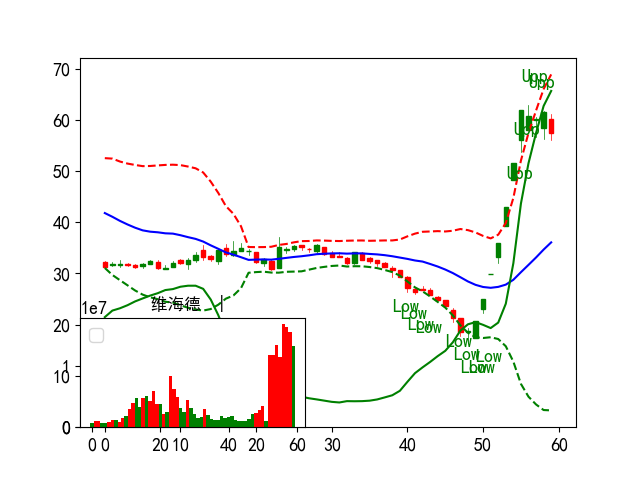

000628 2.17
xratio:-0.1 ra_diff:2.17


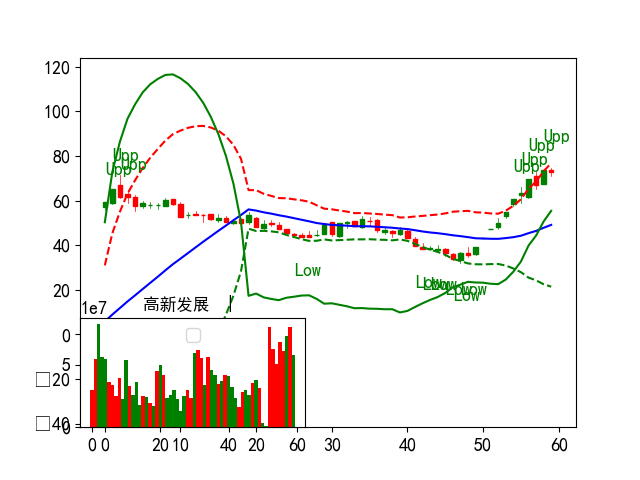

001309 1.5
xratio:-0.38 ra_diff:1.5


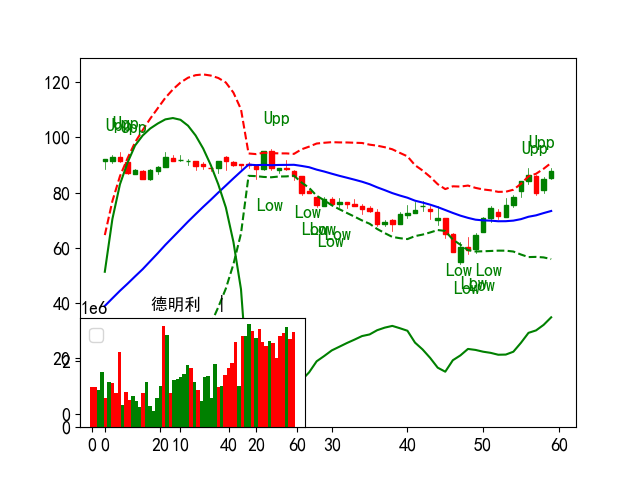

603960 3.25
xratio:0.26 ra_diff:3.25


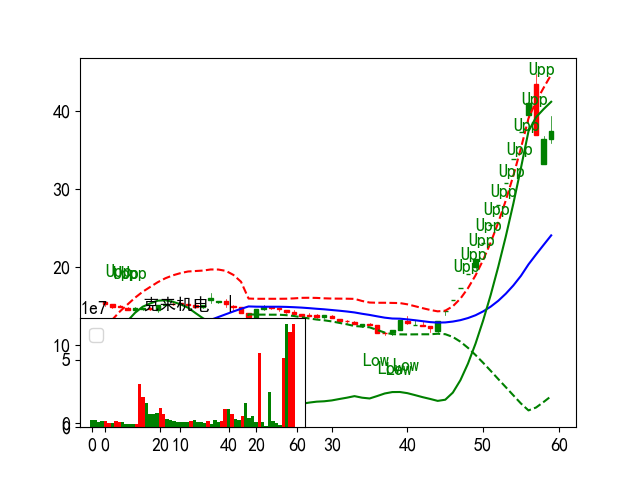

603728 1.86
xratio:-0.58 ra_diff:1.86


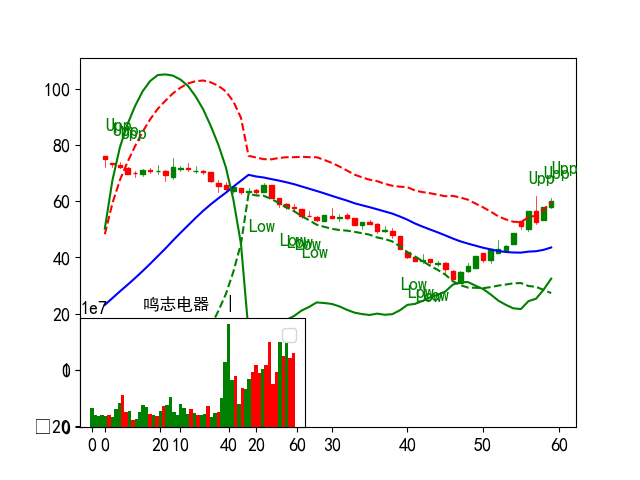

601127 1.65
xratio:-0.17 ra_diff:1.65


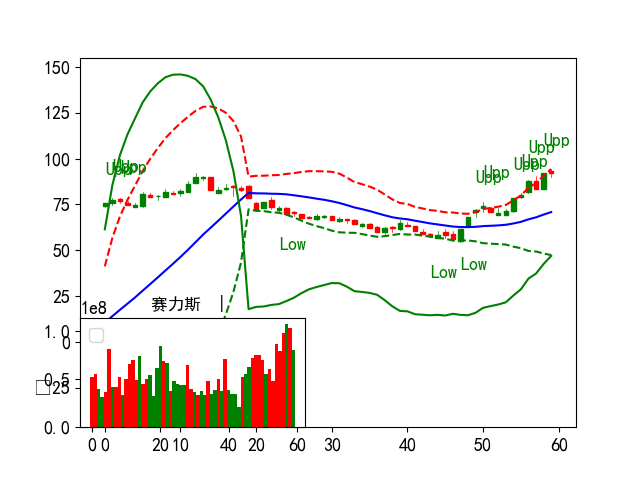

002049 1.58
xratio:-0.2 ra_diff:1.58


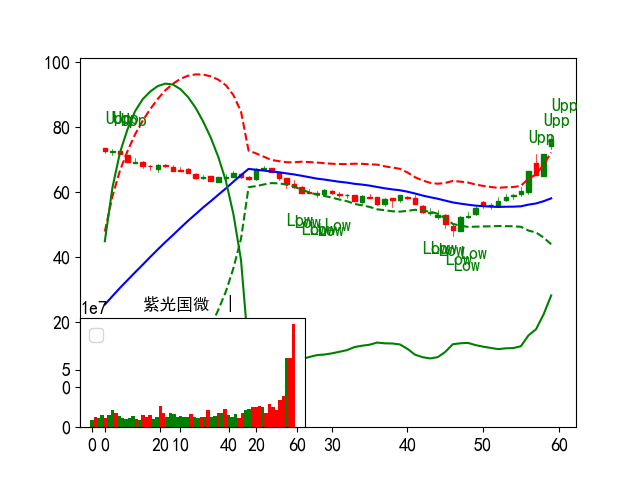

301138 1.9
xratio:-0.12 ra_diff:1.9


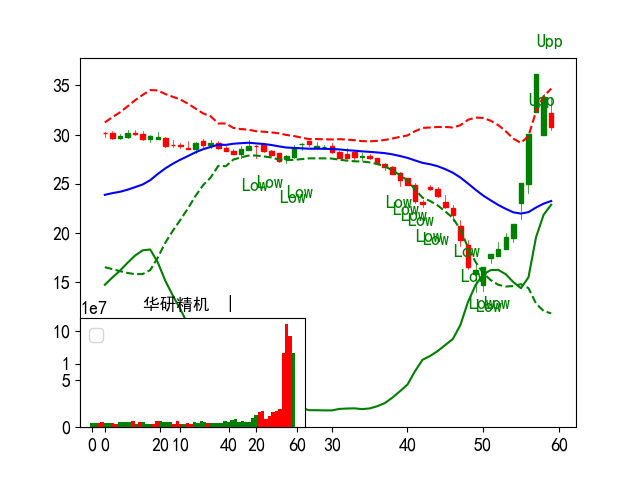

002952 1.97
xratio:0.22 ra_diff:1.97


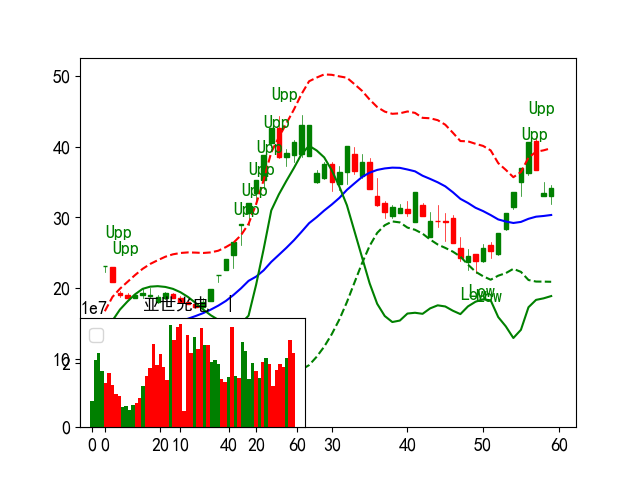

603019 1.78
xratio:-0.02 ra_diff:1.78


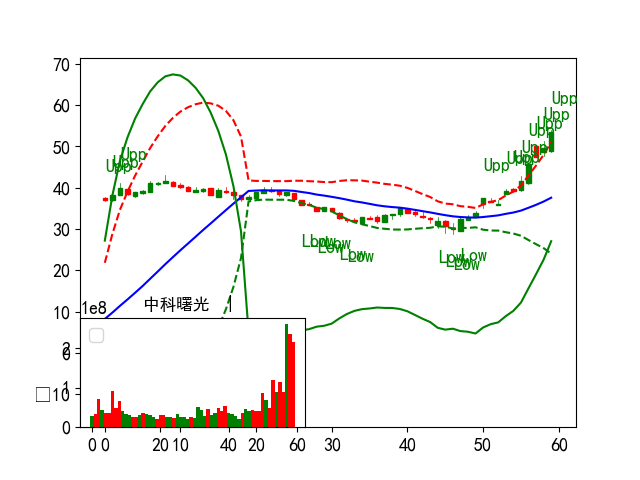

In [99]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [79]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date  lopen  lhigh   llow  close         vol        amount  \
code                                                                      
301318 2024-02-27  58.02  63.00  58.02  57.40  17013435.0  1.018083e+09   
301191 2024-02-27  86.00  99.98  85.00  95.26   4712588.0  4.327715e+08   

        ra_diff   ma10    ma5  ...    idx  couts  nclose  name   open   high  \
code                           ...                                             
301318     3.26  36.64  50.68  ...  42.17      2   58.30   维海德  60.10  61.08   
301191     1.58  76.26  85.92  ...  35.19      1   95.61  菲菱科思  92.51  97.99   

          low  llastp            ticktime  perc  
code                                             
301318  56.01   61.52 2024-03-01 15:00:00 -6.70  
301191  91.13   92.18 2024-03-01 15:00:00  3.34  

[2 rows x 41 columns]

(129, 41)

In [103]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(174, 41)  lastd:(60, 41) 
code
600678    四川金顶
000586    汇源通信
603109    神驰机电
000723    美锦能源
300293    蓝英装备
300785     值得买
002180     纳思达
000938    紫光股份
603327    福蓉科技
300260    新莱应材
603019    中科曙光
300567    精测电子
002733    雄韬股份
002639    雪人股份
300735    光弘科技
301165    锐捷网络
002049    紫光国微
300042    朗科科技
603260    合盛硅业
600895    张江高科
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:69
002403 1.95
xratio:-0.03 ra_diff:1.95


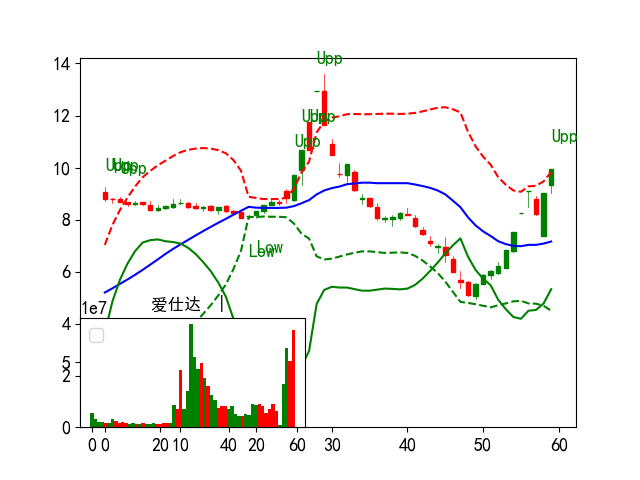

603109 1.87
xratio:-0.02 ra_diff:1.87


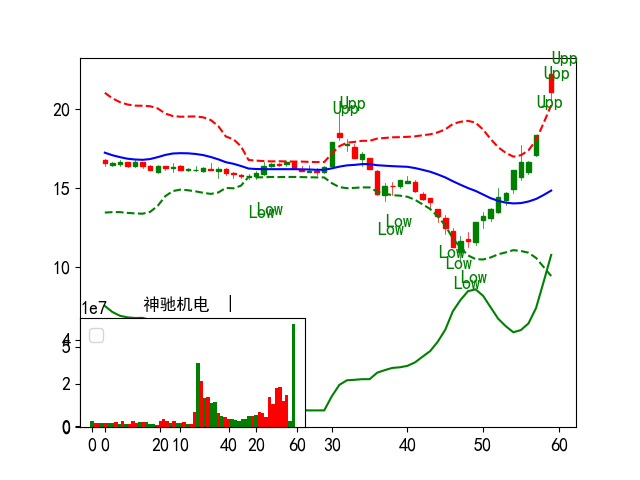

002611 2.15
xratio:0.01 ra_diff:2.15


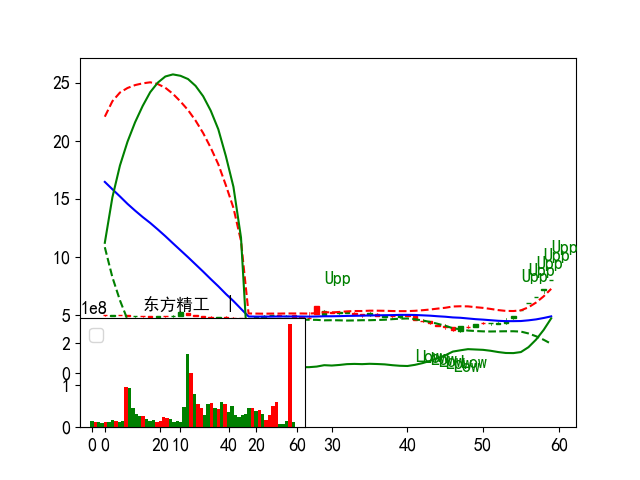

002639 1.43
xratio:-0.03 ra_diff:1.43


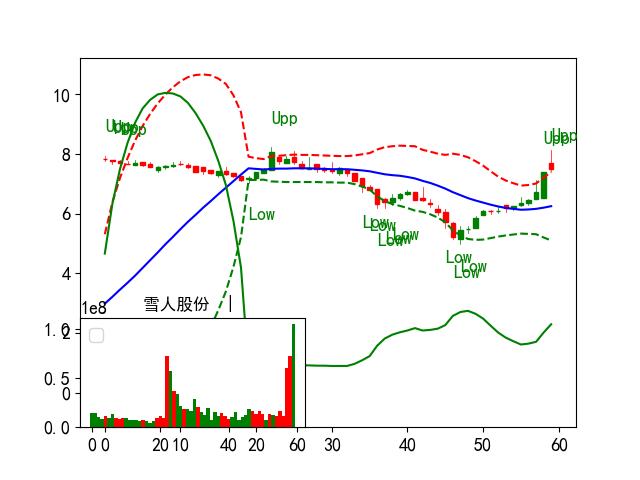

300152 2.19
xratio:-0.01 ra_diff:2.19


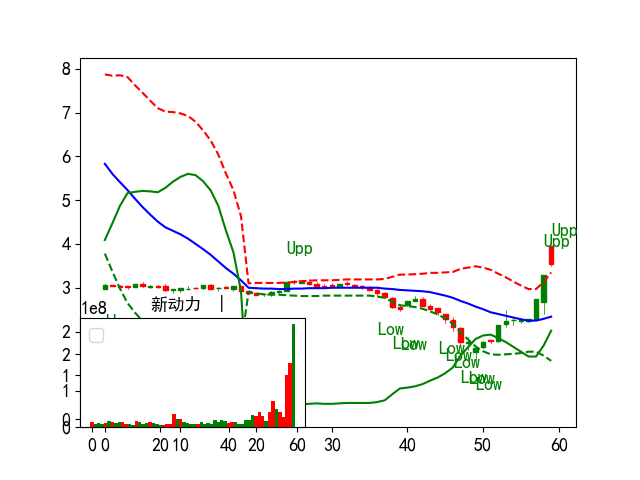

002733 1.47
xratio:-0.05 ra_diff:1.47


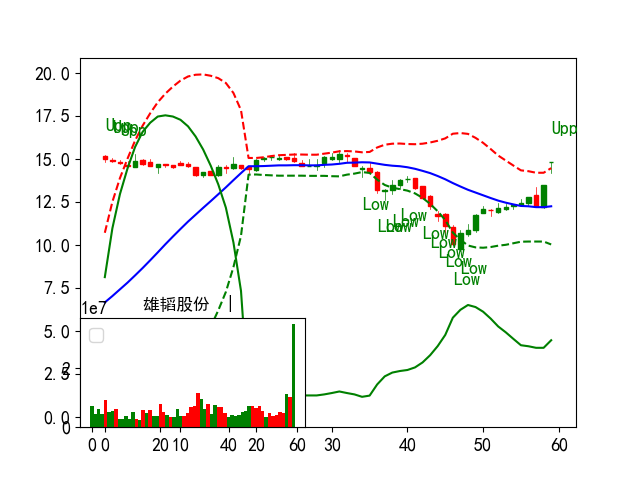

600860 1.64
xratio:-0.07 ra_diff:1.64


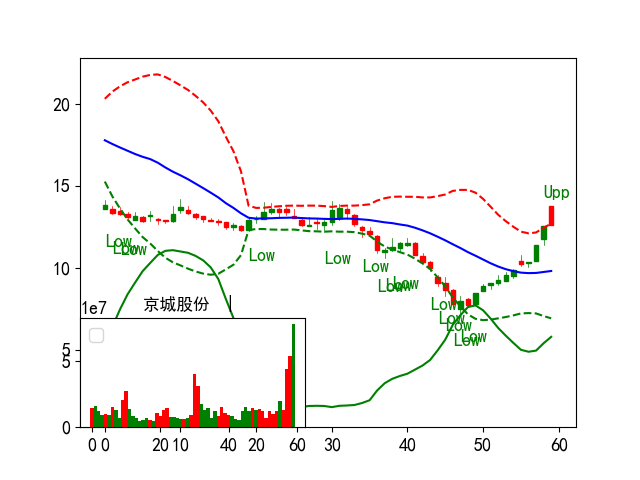

000723 1.61
xratio:-0.03 ra_diff:1.61


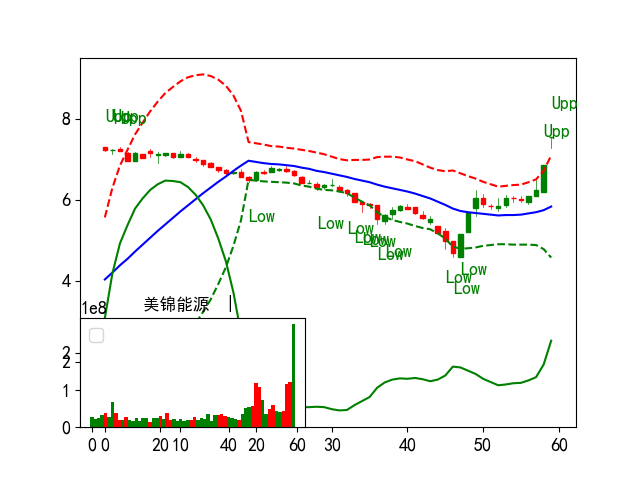

300435 1.29
xratio:-0.04 ra_diff:1.29


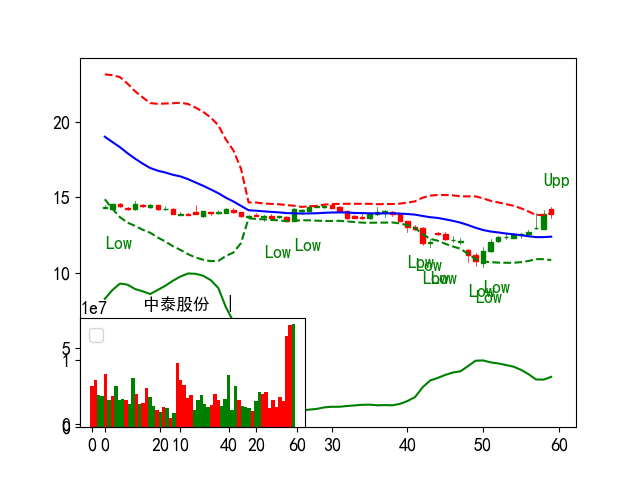

000801 1.47
xratio:-0.0 ra_diff:1.47


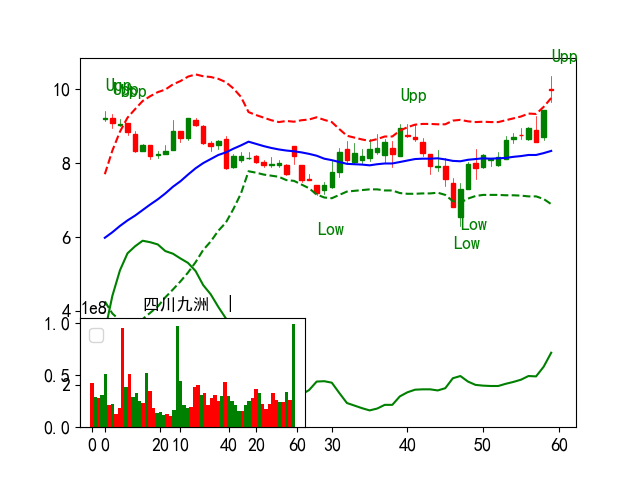

In [104]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:60
600678 1.99
xratio:-0.06 ra_diff:1.99


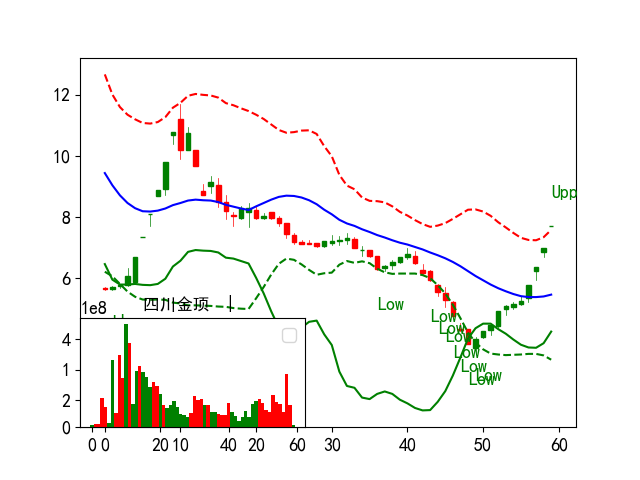

000586 2.1
xratio:-0.09 ra_diff:2.1


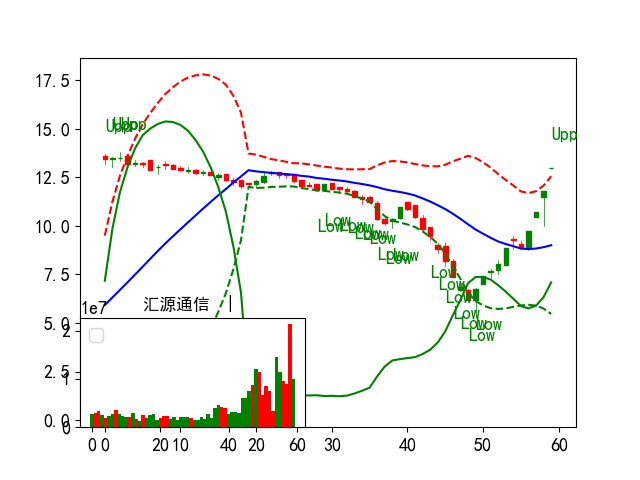

603109 1.87
xratio:-0.02 ra_diff:1.87


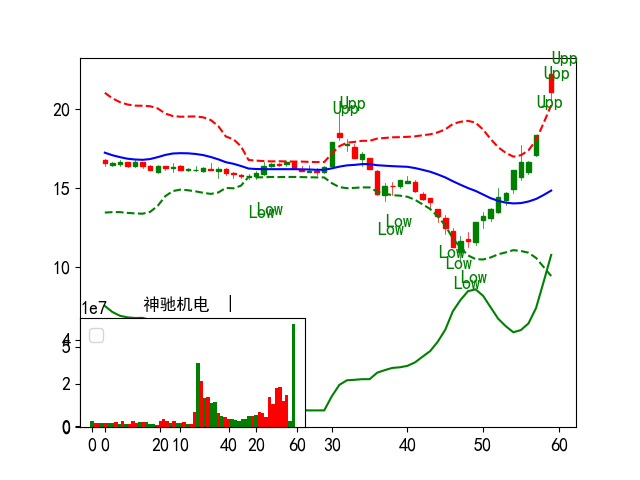

000723 1.61
xratio:-0.03 ra_diff:1.61


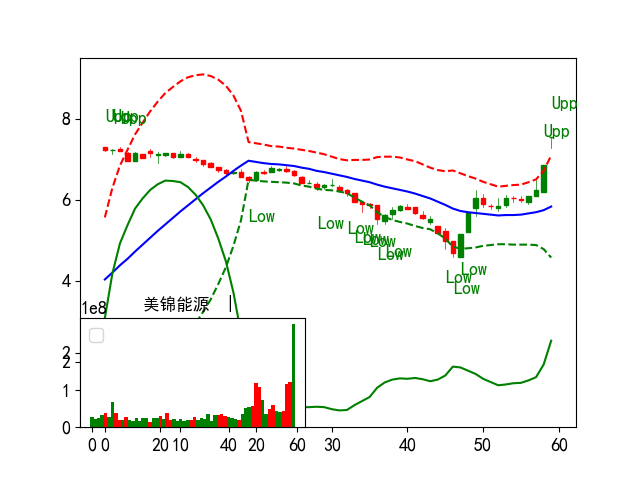

300293 1.92
xratio:-0.08 ra_diff:1.92


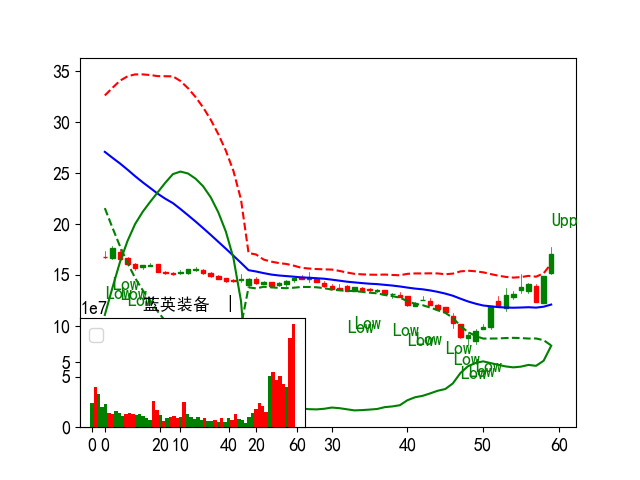

300785 1.66
xratio:-0.15 ra_diff:1.66


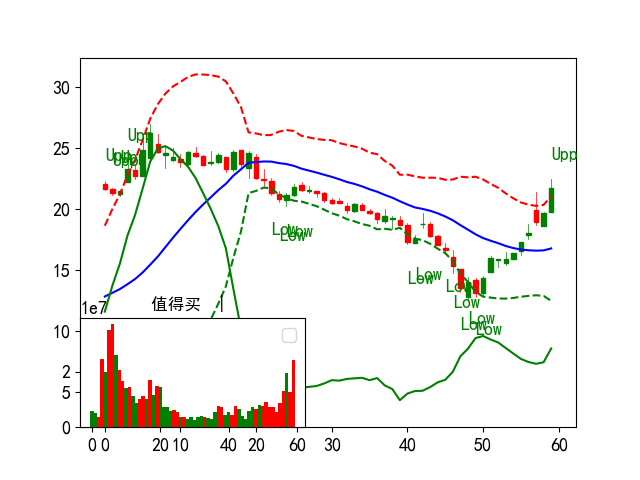

002180 1.49
xratio:-0.11 ra_diff:1.49


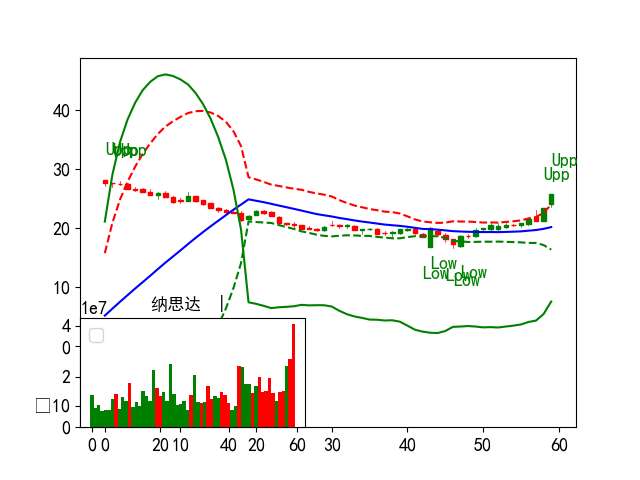

000938 1.65
xratio:-0.04 ra_diff:1.65


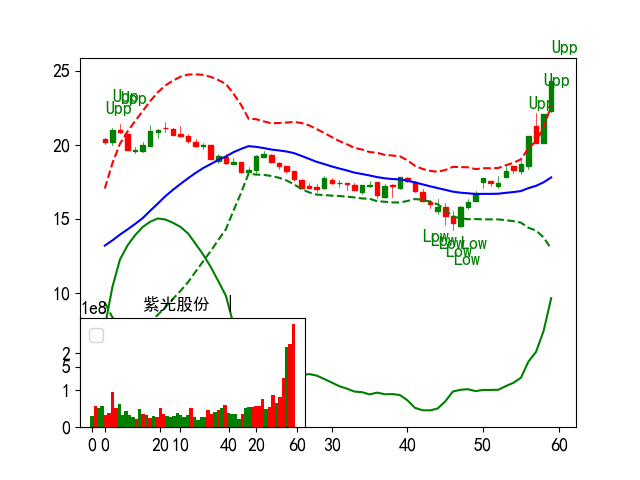

603327 1.54
xratio:-0.08 ra_diff:1.54


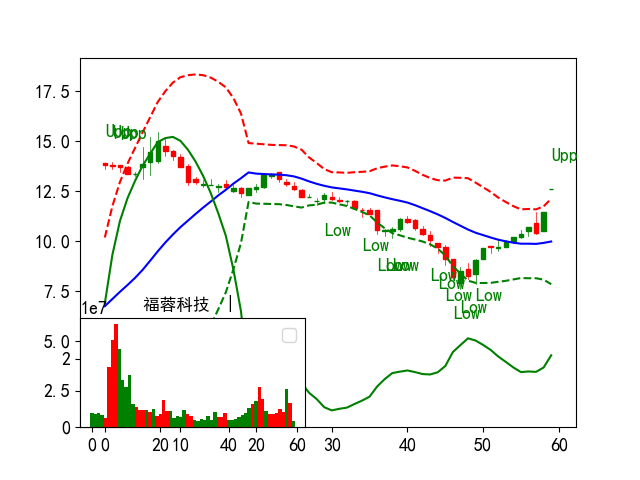

300260 1.65
xratio:-0.24 ra_diff:1.65


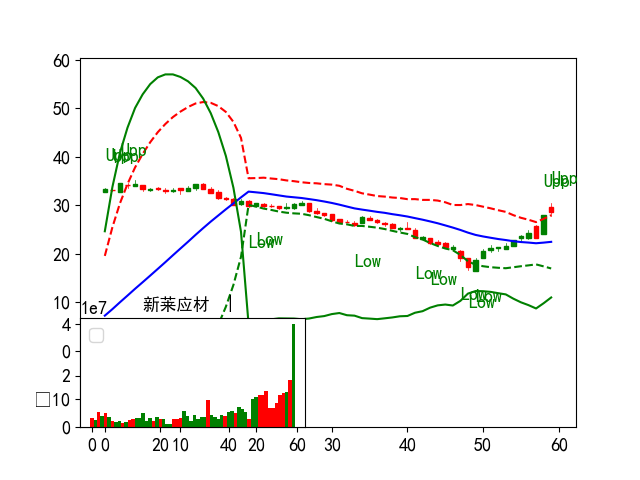

In [105]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [83]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250][:5])

cross_hamx:30
Count:5 41


name  couts       date   perc  ra_diff  xratio   idx    hat  close  \
code                                                                         
600678  四川金顶      1 2024-03-01  10.00     1.99   -0.02  3.42   4.25   7.70   
000586  汇源通信      1 2024-03-01  10.00     2.10   -0.00  5.54   7.09  12.98   
603109  神驰机电      3 2024-03-01   4.62     1.87    0.17  7.86  10.78  21.08   
000723  美锦能源      2 2024-03-01  10.06     1.61    0.05  1.65   2.52   7.55   
300293  蓝英装备      1 2024-03-01  15.00     1.92    0.07  7.17   8.04  17.10   

        volsum5d  ...  ma250  nclose   llow    vol1d   vol2d   vol3d  vol4d  \
code              ...                                                         
600678      60.2  ...   6.84    7.70   7.70   -91.28  -58.75  251.23 -33.66   
000586      42.9  ...   7.47   12.98  12.98   -53.33  140.74   -7.81 -16.22   
603109    1456.8  ...  13.48   21.59  20.40  1546.13  -80.49   24.01 -35.68   
000723     305.1  ...   4.84    7.54   7.28   131.13    4.15  168.62   8.91   
300293     123.4  ...  15.93   15.90  15.12    16.61  122.37   -7.20 -15.23   

        vol5d  perc3d  perc5d  
code                           
600678  -7.33   33.22   49.22  
000586 -20.50   33.13   40.17  
603109   2.80   26.61   30.85  
000723  -7.74   23.77   25.21  
300293   6.85   20.93   30.53  

[5 rows x 24 columns]

df_mask250:30
002403 1.95
xratio:-0.03 ra_diff:1.95


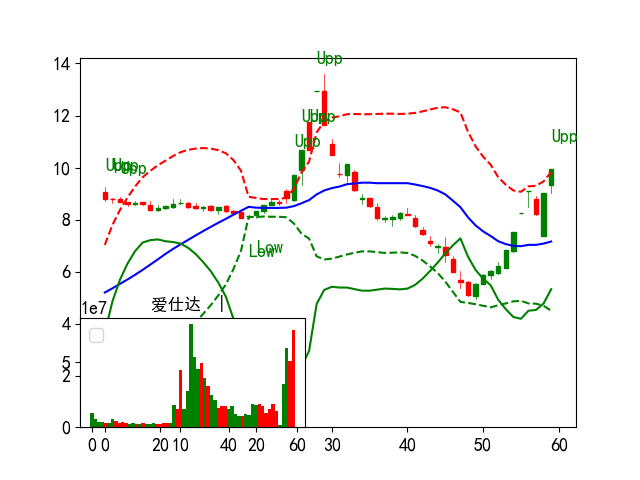

002371 1.35
xratio:0.7 ra_diff:1.35


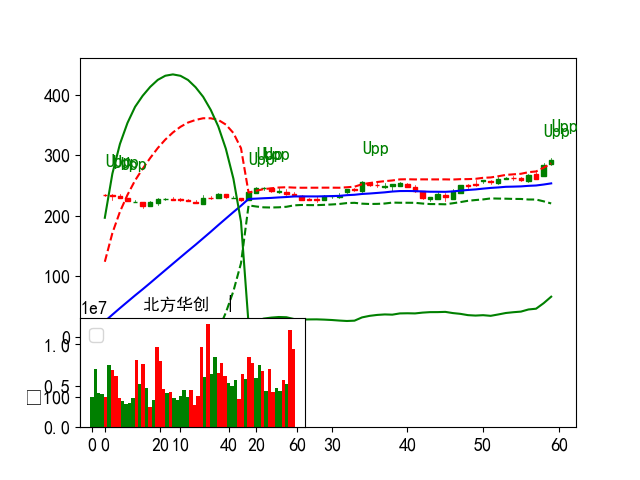

000733 1.41
xratio:-0.27 ra_diff:1.41


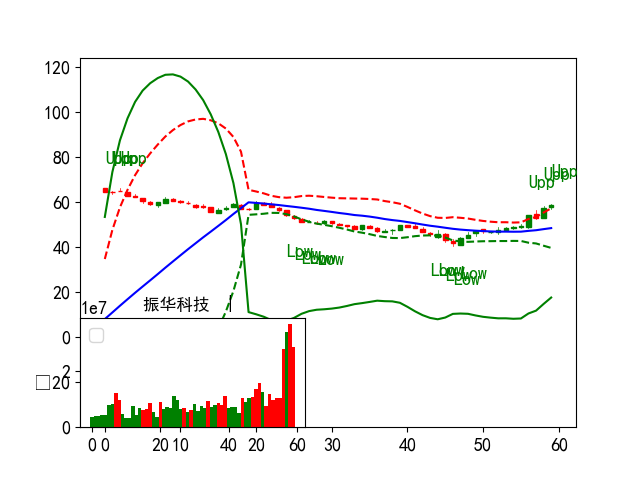

000063 1.41
xratio:-0.01 ra_diff:1.41


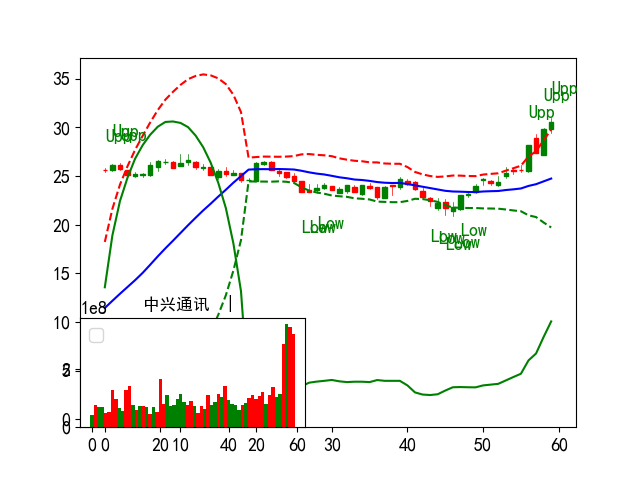

002338 1.55
xratio:-0.21 ra_diff:1.55


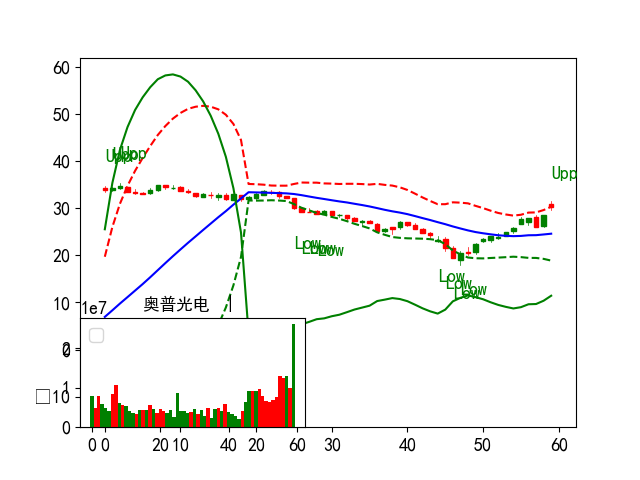

603927 1.41
xratio:-0.11 ra_diff:1.41


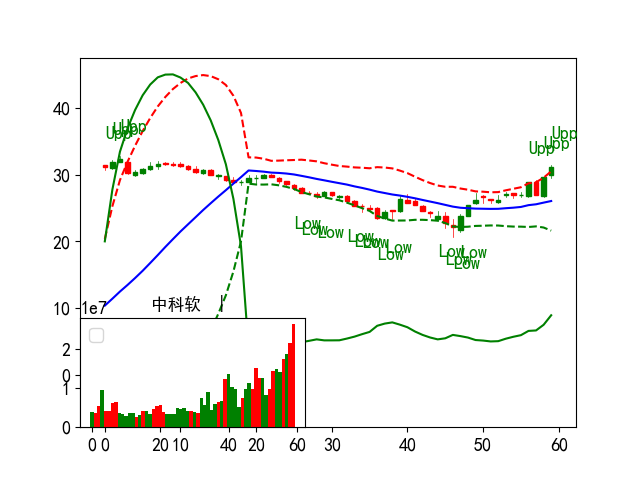

603556 1.39
xratio:0.12 ra_diff:1.39


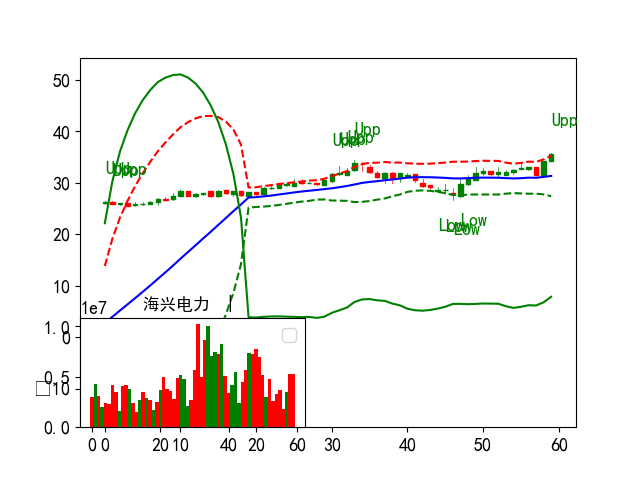

000550 1.47
xratio:0.09 ra_diff:1.47


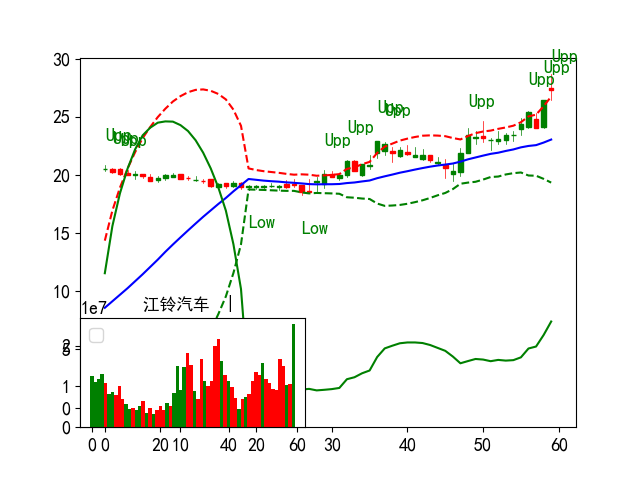

600150 1.3
xratio:0.09 ra_diff:1.3


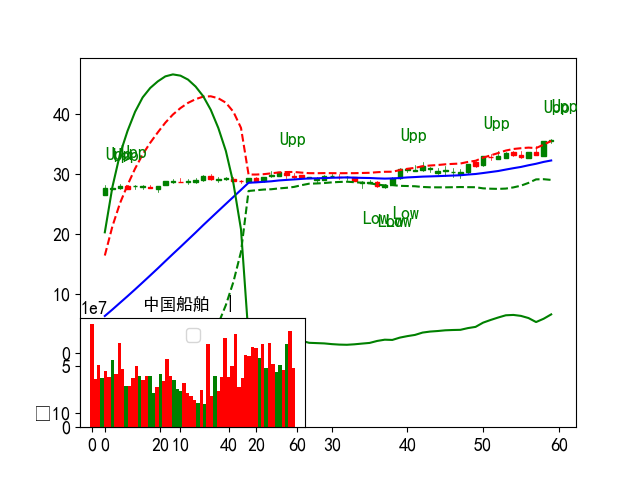

000333 1.31
xratio:0.23 ra_diff:1.31


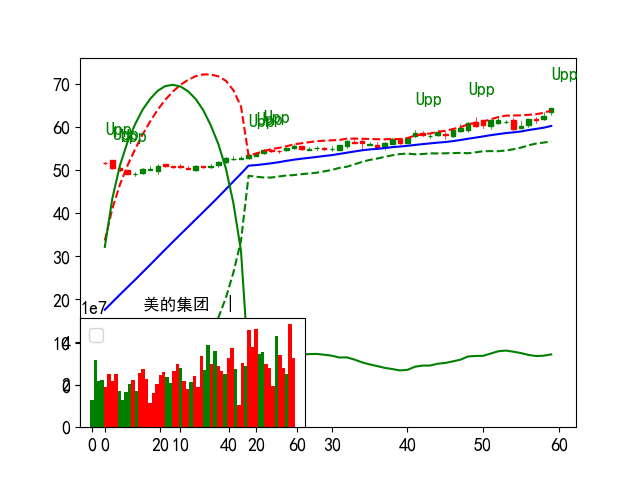

In [106]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [85]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [86]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [87]:
top_temp.shape
top_temp.index

(857, 34)

Index(['603979', '600406', '600660', '603960', '603379', '601899', '601166',
       '601138', '600600', '300308',
       ...
       '000779', '002466', '001283', '300951', '000505', '000551', '000557',
       '000715', '000799', '300990'],
      dtype='object', name='code', length=857)

## plt.close('all')

In [88]:
# plt.close('all')

# 写入060